# 1. Collecting the Data

In [1]:
#import required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense,Dropout, GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
#retains the same output after iteration

tf.random.set_seed(1234)

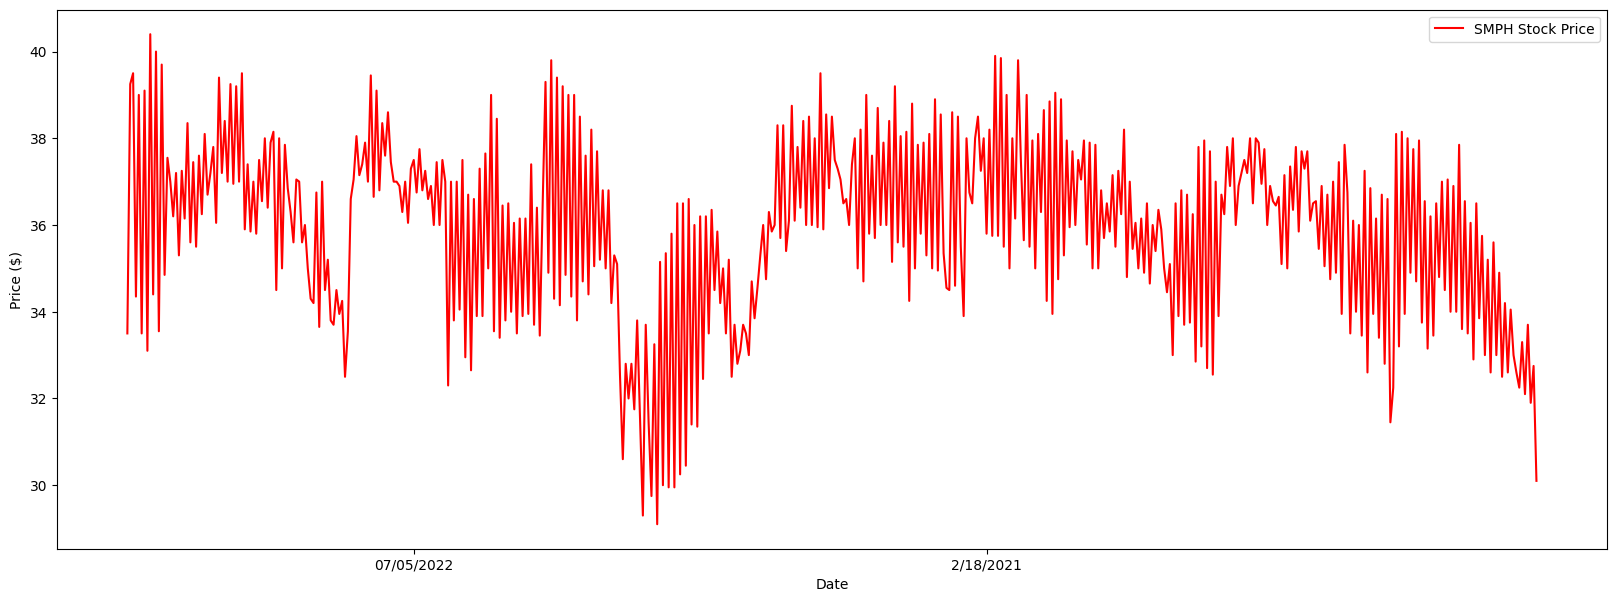

In [3]:
#Load data for graphic visualization

graph = pd.read_csv('SMPH.csv')
graph = graph.sort_values('Date').reset_index(drop=True)

#Plot price 

graph['Price'] = graph['Price'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(graph['Date'].values, graph['Price'].values, label = 'SMPH Stock Price', color = 'red')
plt.xticks(np.arange(100,graph.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [4]:
#Load the dataset
#convert into datetime type

file = 'SMPH.csv'
df = pd.read_csv(file, parse_dates = ['Date'], index_col = 'Date')
df=df.iloc[::-1]
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-10-07,29.30,29.60,29.60,28.90,7.29M,-1.01%
2020-10-08,29.75,29.60,29.80,28.75,3.33M,1.54%
2020-10-09,29.10,29.60,29.60,28.80,7.03M,-2.18%
2020-10-12,30.00,29.10,30.00,28.95,4.61M,3.09%
2020-10-13,29.95,29.95,30.15,29.50,3.52M,-0.17%


# 2. Preparing the Data

In [5]:
#Remove unneeded parameters

df = df.drop(['Vol.'], axis=1)
df = df.drop(['Change %'], axis=1)
df.head()

,Price,Open,High,Low
Date,,,,
2020-10-07,29.30,29.60,29.60,28.90
2020-10-08,29.75,29.60,29.80,28.75
2020-10-09,29.10,29.60,29.60,28.80
2020-10-12,30.00,29.10,30.00,28.95
2020-10-13,29.95,29.95,30.15,29.50


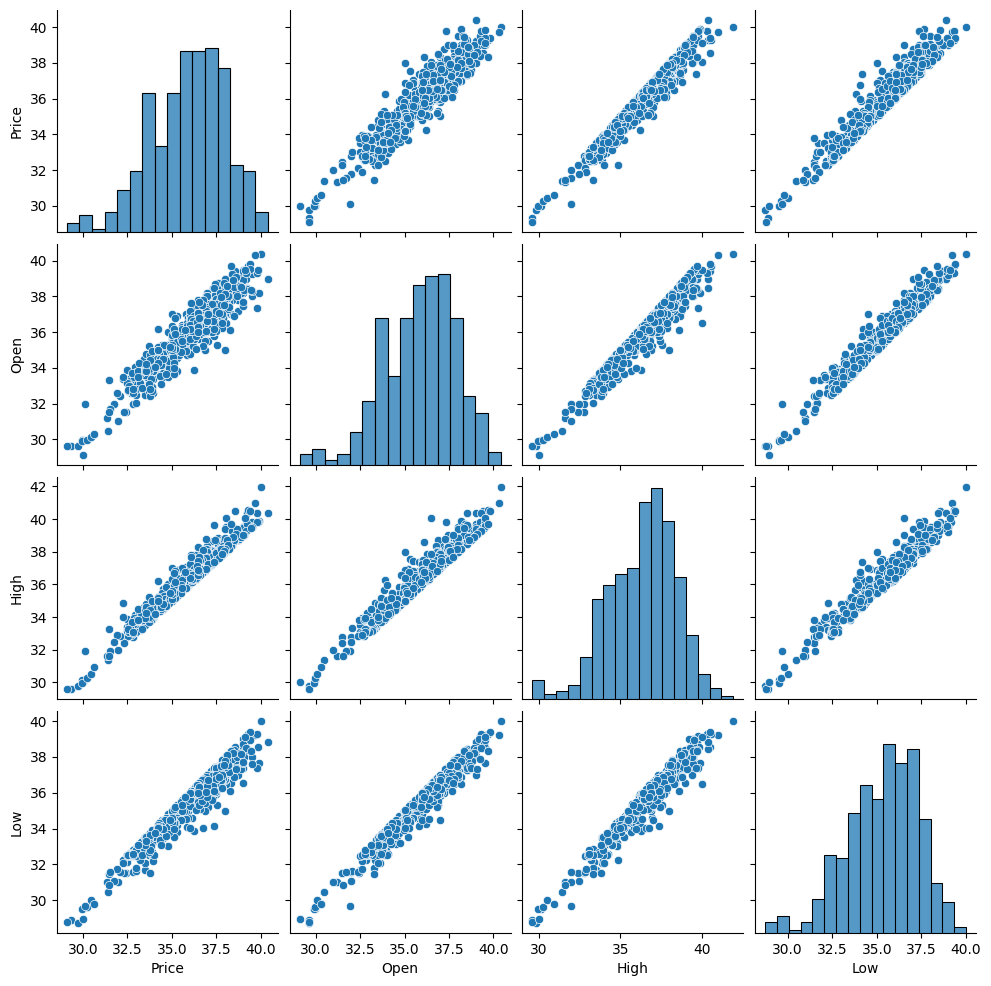

In [6]:
sns.pairplot(df)

In [7]:
#Determine missing values
#There are no missing values 

print('Total num of missing values:') 
print(df.isna().sum())

Total num of missing values:
Price    0
Open     0
High     0
Low      0
dtype: int64


In [8]:
#Split train and test data
#Define training size
train_size = int(len(df)*0.8)

#categorize training and testing data
#select number of rows through iloc
train_data = df.iloc[:train_size, 1:2].values
test_data = df.iloc[train_size:, 1:2].values
df.shape

(493, 4)

In [9]:
#Apply scaler to train and test
#Normalize data 

scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [10]:
#Define input dataset
#Create look back for data prediction  

def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

In [11]:
#Show size of test variable

X_test[:33].shape

(33, 30, 1)

# 3-4. Choosing and Training the Model (GRU)

In [12]:
#define GRU model

def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model
model_gru = create_gru(64)

In [13]:
#train model with set parameters 

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 220, validation_split = 0.2,
                    batch_size = 16, shuffle = False)
    return history

history_gru = fit_model(model_gru)

Epoch 1/220
19/19 [==============================] - 3s 46ms/step - loss: 0.1436 - val_loss: 0.0063
Epoch 2/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0097 - val_loss: 0.0106
Epoch 3/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 4/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 5/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 6/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 7/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0079
Epoch 8/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 9/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0085 - val_loss: 0.0113
Epoch 10/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0088 - val_loss: 0.0098

19/19 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 83/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 84/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 85/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 86/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 87/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 88/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0075
Epoch 89/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 90/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 91/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0082
Epo

19/19 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 163/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 164/220
19/19 [==============================] - 0s 16ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 165/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 166/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 167/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 168/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 169/220
19/19 [==============================] - 0s 14ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 170/220
19/19 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 171/220
19/19 [==============================] - 0s 15ms/step - loss: 0.0042 - val_loss: 0

# 5-6. Evaluating the Model 

3/3 [==============================] - 0s 4ms/step
GRU:
Mean Absolute Error: 0.5059
Root Mean Square Error: 0.6503



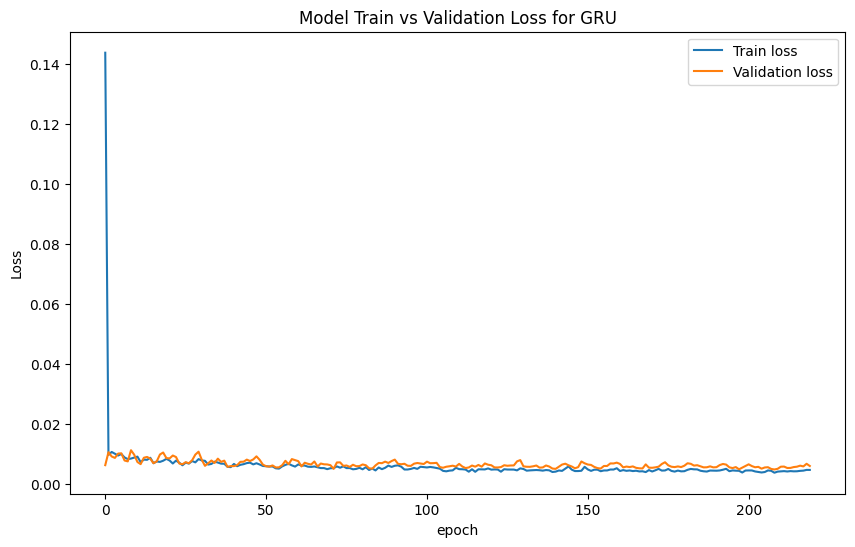

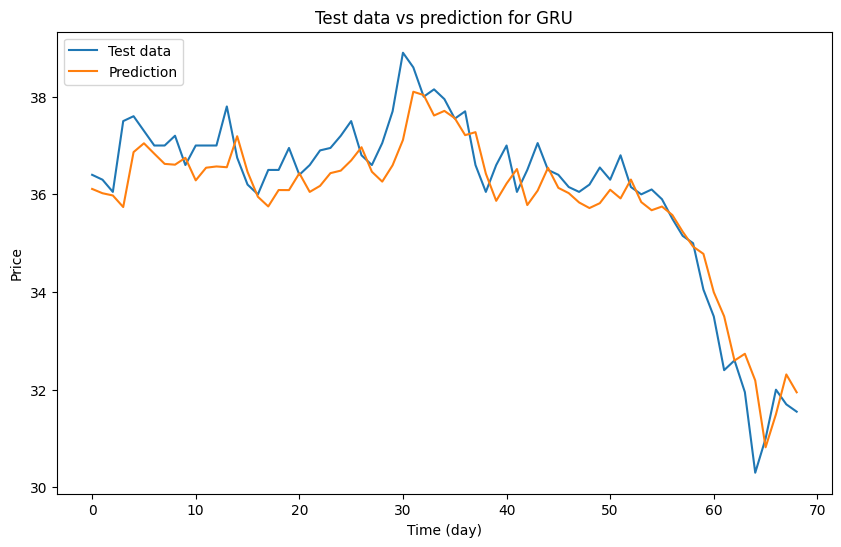

In [14]:
# Plot train loss and validation loss

def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss (history_gru, 'GRU')

# Transform data back to original form
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

#Create prediction
#Compare prediction vs test data

def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Price')
    
plot_future(prediction_gru, 'GRU', y_test)

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_gru, y_test, 'GRU')

# 7. Making predictions

In [15]:
# Select 42 days of data from test data
new_data = test_data[0:42]

# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape) 

X_30.shape:  (12, 30, 1)


1/1 [==============================] - 0s 13ms/step


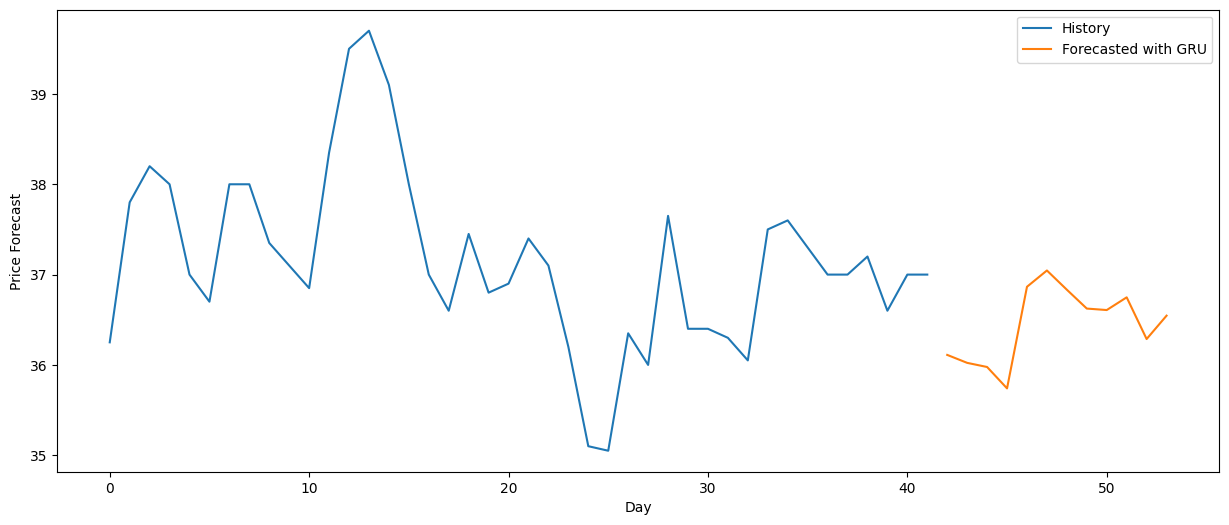

In [16]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)

# Plot history and future data
def plot_multi_step(history, prediction1):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with GRU')
    plt.legend(loc='upper right')
    plt.xlabel('Day')
    plt.ylabel('Price Forecast')
    
plot_multi_step(new_data, prediction_gru)

In [17]:
#Determine prediction within the days after october 7 

prediction_gru

array([[36.110855],
       [36.022755],
       [35.976933],
       [35.740135],
       [36.86512 ],
       [37.045456],
       [36.832493],
       [36.623882],
       [36.607513],
       [36.74815 ],
       [36.286522],
       [36.545334]], dtype=float32)